✅ Output will be saved to 'Sep_21/'

--- Creating and Saving Summary Table ---
✅ Saved summary to Sep_21/evaluation_summary.csv


,Environment,TrainSamples,EncodeDimMultiplier,LearnedEncodeDim,ActualEncodeDim,UseCovLoss,UseControlLoss,PredictionError,NormalizedCovariance
0,DampingPendulum,1000,1,2,4,False,False,0.014942,6.611577e+05
1,DampingPendulum,1000,1,2,4,False,True,0.097864,2.747380e+03
2,DampingPendulum,1000,1,2,4,True,False,0.020307,2.094539e-07
3,DampingPendulum,1000,1,2,4,True,True,0.150161,1.223969e-04
4,DampingPendulum,1000,2,4,6,False,False,0.022343,1.270932e+04
...,...,...,...,...,...,...,...,...,...
595,Kinova,140000,8,112,126,True,True,0.029522,5.465351e-04
596,Kinova,140000,16,224,238,False,False,0.000902,1.303512e-01
597,Kinova,140000,16,224,238,False,True,0.006252,1.643209e+00
598,Kinova,140000,16,224,238,True,False,0.000952,5.967728e-05



--- Generating Scaling Law Plots (Train Samples vs. Error) ---


/tmp/ipykernel_1323505/2200210187.py:225: UserWarning: The figure layout has changed to tight
  fig_ts.tight_layout(rect=[0, 0.03, 1, 0.95])


🖼️ Saved combined plot: Sep_21/AllEnvs_ScalingLaw_TrainSamples.png

--- Generating Scaling Law Plots (Encode Dim vs. Error) ---


/tmp/ipykernel_1323505/2200210187.py:301: UserWarning: The figure layout has changed to tight
  fig_ed.tight_layout(rect=[0, 0.03, 1, 0.95])


🖼️ Saved combined plot: Sep_21/AllEnvs_ScalingLaw_EncodeDim.png

✅ Saved all scaling-law fit parameters to Sep_21/scaling_law_fits.csv


,Environment,Variable,A,alpha,C,R2_linear
0,DampingPendulum,TrainSamples,1.148930e+01,1.050358,8.889667e-03,0.909920
1,Franka,TrainSamples,2.585557e-08,0.500000,2.250629e-08,-0.013200
2,DoublePendulum,TrainSamples,5.019703e+01,1.289394,1.662887e-02,0.999092
3,Kinova,TrainSamples,2.142168e+01,1.157175,5.435130e-03,0.999618
4,G1,TrainSamples,1.649237e+01,0.683586,1.285602e-01,0.999738
5,Go2,TrainSamples,3.591633e+01,0.797428,2.050454e-01,0.999709
6,DampingPendulum,EncodeDim,3.392100e+01,4.000000,7.018384e-03,0.775928
7,Franka,EncodeDim,7.736079e-04,1.643937,1.269254e-07,0.666624
8,DoublePendulum,EncodeDim,2.352321e+00,3.999785,1.671024e-02,0.609000
9,Kinova,EncodeDim,2.673386e+01,1.311118,1.281955e-18,0.986817



--- Generating Correlation Plot ---
🖼️ Saved correlation plot to Sep_21/error_vs_covariance_trend.png


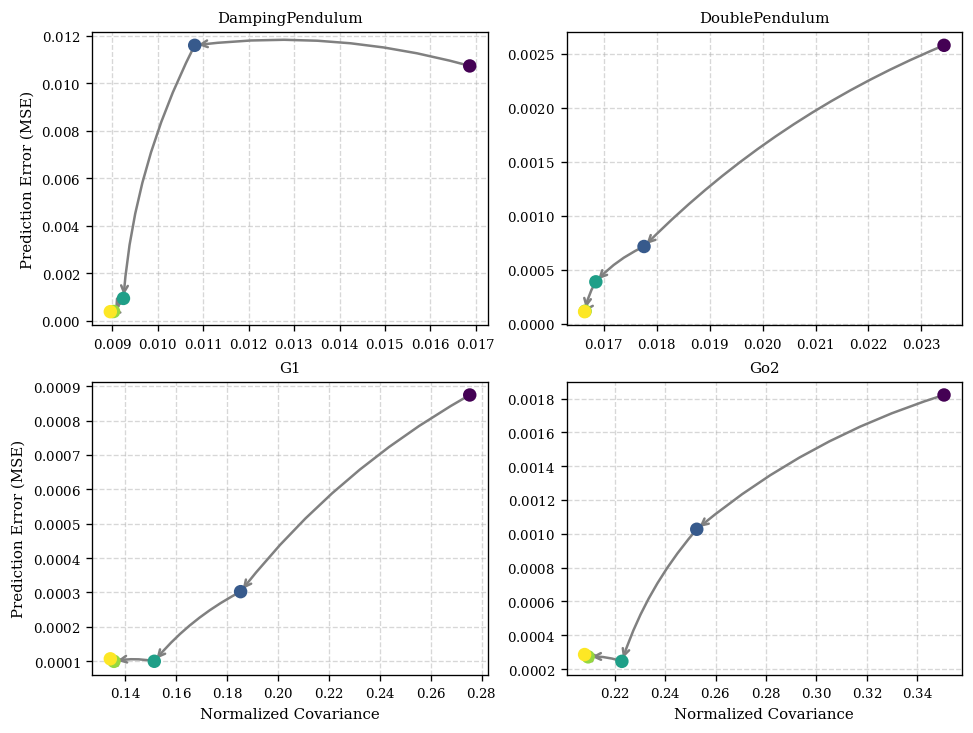

In [28]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.optimize import curve_fit

mpl.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "lines.linewidth": 1.4,
    "lines.markersize": 5.5,
    "axes.formatter.use_mathtext": True,
    "pdf.fonttype": 42,   # embed TrueType for Illustrator/journal pipelines
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.prop_cycle": mpl.cycler(color=plt.cm.tab10.colors)
})

# ============================
# Configuration
# ============================
# Project name to save the generated plots and data
PROJECT_NAME = "Sep_21"

ENVS          = ["DampingPendulum", "Franka", "DoublePendulum", "Kinova", "G1", "Go2"]
SEEDS         = [17382, 76849, 20965, 84902, 51194]
TRAIN_SAMPLES = [1000, 4000, 16000, 64000, 140000]
M_POLY        = 100

U_DIM = {"Franka": 7, "DoublePendulum": 2, "DampingPendulum": 1, "G1": 23, "Go2": 12, "Kinova": 7}
NORMALIZE = {"G1": "norm", "Go2": "norm"}
REL_MULT_TARGETS = [1, 2, 4, 8, 16]

# ============================
# Helpers
# ============================
def gmean(vals, eps: float = 1e-12) -> float:
    """Computes the geometric mean of a list of values."""
    arr = np.asarray(list(vals), dtype=float)
    arr = np.maximum(arr, eps)
    return float(np.exp(np.mean(np.log(arr))))

def env_has_control(env: str) -> bool:
    """Checks if an environment uses a control input."""
    return U_DIM.get(env, 0) > 0

def find_dataset_path(env: str, m_val: int, ksteps: int = 15) -> str | None:
    """Constructs the expected path to a dataset file."""
    norm = NORMALIZE.get(env, "nonorm")
    base_path = os.path.join("..", "data", "datasets")
    if env == "Polynomial":
        path = os.path.join(base_path, f"dataset_{env}_{norm}_m_{m_val}_Ktrain_140000_Kval_20000_Ktest_20000_Ksteps_1.pt")
    else:
        path = os.path.join(base_path, f"dataset_{env}_{norm}_Ktrain_140000_Kval_20000_Ktest_20000_Ksteps_{ksteps}.pt")
    return path if os.path.exists(path) else None

# ============================
# 1) Load and Validate CSV Log
# ============================
# Point to the original project's log file
log_csv = os.path.join("..", "log", "Sep_21", "koopman_results_log.csv")
assert os.path.exists(log_csv), f"❌ CSV log not found: {log_csv}"
log = pd.read_csv(log_csv)

required_cols = ["env_name", "seed", "train_samples", "encode_dim", "test_Kloss", "test_CovLoss", "encode_dim_param"]
for col in required_cols:
    assert col in log.columns, f"❌ Log file is missing required column: '{col}'"

# Create a new output directory for the plots and results
os.makedirs(PROJECT_NAME, exist_ok=True)
print(f"✅ Output will be saved to '{PROJECT_NAME}/'")

# ============================
# 2) Filter Log and Calculate Actual Encode Dimension (z)
# ============================
mask = (
    log['env_name'].isin(ENVS) &
    log['seed'].isin(SEEDS) &
    log['train_samples'].isin(TRAIN_SAMPLES) &
    log['encode_dim_param'].isin(REL_MULT_TARGETS) &
    ((log['env_name'] != 'Polynomial') | (log['m'] == M_POLY))
)
filtered_log = log[mask].copy()

# **Calculate the actual encode dimension `z` by adding the state dimension**
filtered_log['z_dim'] = filtered_log['encode_dim'] + filtered_log['state_dim']

if filtered_log.empty:
    print("❌ No matching experiments found after filtering. Please check your configuration.")
    raise SystemExit(0)

# ============================
# 3) Aggregate Results and Save Summary Table
# ============================
print("\n--- Creating and Saving Summary Table ---")

def normalize_cov(row):
    # This normalization uses the learned encode_dim, not z_dim
    learned_dim = row['encode_dim']
    if learned_dim <= 1:
        return row['test_CovLoss']
    denominator = learned_dim * (learned_dim - 1)
    return row['test_CovLoss'] / denominator

summary_df = filtered_log.copy()
summary_df['NormalizedCovariance'] = summary_df.apply(normalize_cov, axis=1)

# **MODIFIED**: Added 'encode_dim_param' to the grouping keys
grouping_keys = [
    "env_name", "train_samples", "encode_dim_param", "encode_dim", "z_dim",
    "use_covariance_loss", "use_control_loss"
]
df_agg = summary_df.groupby(grouping_keys).agg(
    PredictionError=("test_Kloss", gmean),
    NormalizedCovariance=("NormalizedCovariance", gmean)
).reset_index()

# **MODIFIED**: Renamed 'encode_dim_param' for the final table
df = df_agg.rename(columns={
    "env_name": "Environment",
    "train_samples": "TrainSamples",
    "encode_dim_param": "EncodeDimMultiplier",
    "encode_dim": "LearnedEncodeDim",
    "z_dim": "ActualEncodeDim",
    "use_covariance_loss": "UseCovLoss",
    "use_control_loss": "UseControlLoss"
})

out_csv = os.path.join(PROJECT_NAME, "evaluation_summary.csv")
df.to_csv(out_csv, index=False)
print(f"✅ Saved summary to {out_csv}")
if not df.empty:
    display(df)


# ============================
# 4) Define Scaling Law Model
# ============================
def scaling_model(D, A, alpha, C):
    """Scaling law model: Error = A * D^(-alpha) + C"""
    return A * np.power(D, -alpha) + C

# ============================
# 5) Generate Scaling Law Subplots for Train Sample Size
# ============================
print("\n--- Generating Scaling Law Plots (Train Samples vs. Error) ---")
fig_ts, axes_ts = plt.subplots(2, 3, figsize=(12, 7), sharey=False)
axes_ts = axes_ts.flatten()

fit_results_ts = []

for i, env in enumerate(ENVS):
    ax = axes_ts[i]
    sub_df = filtered_log[(filtered_log.env_name == env) & (filtered_log.use_covariance_loss == 1)].copy()
    if env_has_control(env) and "use_control_loss" in filtered_log.columns:
        sub_df = sub_df[sub_df.use_control_loss == 1]

    if sub_df.empty:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(env)
        continue

    max_z_dim = sub_df['z_dim'].max()
    plot_data = sub_df[sub_df['z_dim'] == max_z_dim]

    ax.set_title(f"{env}")

    if plot_data.shape[0] < 3:
        ax.text(0.5, 0.5, f"Not enough data points ({plot_data.shape[0]})", ha='center', va='center', transform=ax.transAxes)
        continue

    D, E = plot_data["train_samples"].astype(float).to_numpy(), plot_data["test_Kloss"].astype(float).to_numpy()
    
    ax.plot(D, E, "o", label="Data (all seeds)", alpha=0.4)

    try:
        popt, _ = curve_fit(scaling_model, D, E, p0=[E.max(), 0.5, E.min()],
                            bounds=([0.0, 0.0, 0.0], [np.inf, 4.0, np.inf]), maxfev=20000)
        A_hat, alpha_hat, C_hat = popt
        ss_res = np.sum((E - scaling_model(D, *popt)) ** 2)
        ss_tot = np.sum((E - np.mean(E)) ** 2)
        R2 = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else float("nan")

        fit_results_ts.append({
            "Environment": env, "Variable": "TrainSamples", "A": A_hat,
            "alpha": alpha_hat, "C": C_hat, "R2_linear": R2
        })

        D_fit_vals = np.unique(D)
        D_fit = np.geomspace(D_fit_vals.min(), D_fit_vals.max(), 100)
        E_fit = scaling_model(D_fit, *popt)
        ax.plot(D_fit, E_fit, "-", color='red', linewidth=2,
                label=f"Fit: $\\alpha={alpha_hat:.2f}, C={C_hat:.2e}$ ($R^2={R2:.2f}$)")
    except Exception as ex:
        print(f"⚠️ Could not fit TrainSamples scaling law for {env}: {ex}")
    
    row, col = divmod(i, 3)

    if col == 0:
        ax.set_ylabel("Prediction Error (MSE)")
    else:
        ax.set_ylabel("")

    if row == 1:
        ax.set_xlabel("Training Samples ($n$)")
    else:
        ax.set_xlabel("")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

fig_ts.tight_layout(rect=[0, 0.03, 1, 0.95])
plot_path_ts = os.path.join(PROJECT_NAME, "AllEnvs_ScalingLaw_TrainSamples.png")
fig_ts.savefig(plot_path_ts, dpi=300)
plt.close(fig_ts)
print(f"🖼️ Saved combined plot: {plot_path_ts}")

# ============================
# 6) Generate Scaling Law Subplots for Encode Dimension
# ============================
print("\n--- Generating Scaling Law Plots (Encode Dim vs. Error) ---")
fig_ed, axes_ed = plt.subplots(2, 3, figsize=(12, 7), sharey=False)
axes_ed = axes_ed.flatten()

fit_results_ed = []

for i, env in enumerate(ENVS):
    ax = axes_ed[i]
    sub_df = filtered_log[(filtered_log.env_name == env) & (filtered_log.use_covariance_loss == 1)].copy()
    if env_has_control(env) and "use_control_loss" in filtered_log.columns:
        sub_df = sub_df[sub_df.use_control_loss == 1]

    if sub_df.empty:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(env)
        continue

    max_train_samples = sub_df['train_samples'].max()
    plot_data = sub_df[sub_df['train_samples'] == max_train_samples]

    ax.set_title(f"{env}")
    
    if plot_data.shape[0] < 3:
        ax.text(0.5, 0.5, f"Not enough data points ({plot_data.shape[0]})", ha='center', va='center', transform=ax.transAxes)
        continue

    D, E = plot_data["z_dim"].astype(float).to_numpy(), plot_data["test_Kloss"].astype(float).to_numpy()
    
    ax.plot(D, E, "o", label="Data (all seeds)", alpha=0.4)

    try:
        popt, _ = curve_fit(scaling_model, D, E, p0=[E.max(), 0.5, E.min()],
                            bounds=([0.0, 0.0, 0.0], [np.inf, 4.0, np.inf]), maxfev=20000)
        A_hat, alpha_hat, C_hat = popt
        ss_res = np.sum((E - scaling_model(D, *popt)) ** 2)
        ss_tot = np.sum((E - np.mean(E)) ** 2)
        R2 = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else float("nan")
        
        fit_results_ed.append({
            "Environment": env, "Variable": "EncodeDim", "A": A_hat,
            "alpha": alpha_hat, "C": C_hat, "R2_linear": R2
        })

        D_fit_vals = np.unique(D)
        D_fit = np.geomspace(D_fit_vals.min(), D_fit_vals.max(), 100)
        E_fit = scaling_model(D_fit, *popt)
        ax.plot(D_fit, E_fit, "-", color='green', linewidth=2,
                label=f"Fit: $\\alpha={alpha_hat:.2f}, C={C_hat:.2e}$ ($R^2={R2:.2f}$)")
    except Exception as ex:
        print(f"⚠️ Could not fit EncodeDim scaling law for {env}: {ex}")

    row, col = divmod(i, 3)
    if col == 0:
        ax.set_ylabel("Prediction Error (MSE)")
    else:
        ax.set_ylabel("")

    if row == 1:
        ax.set_xlabel("Encode Dimension ($z$)")
    else:
        ax.set_xlabel("")

    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

fig_ed.tight_layout(rect=[0, 0.03, 1, 0.95])
plot_path_ed = os.path.join(PROJECT_NAME, "AllEnvs_ScalingLaw_EncodeDim.png")
fig_ed.savefig(plot_path_ed, dpi=300)
plt.close(fig_ed)
print(f"🖼️ Saved combined plot: {plot_path_ed}")

# ============================
# 7) Save All Fit Results
# ============================
if fit_results_ts or fit_results_ed:
    all_fits = pd.DataFrame(fit_results_ts + fit_results_ed)
    out_csv = os.path.join(PROJECT_NAME, "scaling_law_fits.csv")
    all_fits.to_csv(out_csv, index=False)
    print(f"\n✅ Saved all scaling-law fit parameters to {out_csv}")
    display(all_fits)

# ============================
# 8) Plotting Correlation
# ============================
print("\n--- Generating Correlation Plot ---")

# **MODIFICATION 1: Define the list of environments you want to display**
ENVS_TO_PLOT = ["DampingPendulum", "DoublePendulum", "G1", "Go2"]

# Prepare the data by filtering for the largest model size
# This ensures we are comparing fairly, isolating the effect of training samples
plot_df = df[(df['EncodeDimMultiplier'] == 16) & 
             (df['UseCovLoss'] == True) & 
             (df['UseControlLoss'].isin([True, np.nan]))] # Handles envs without control

# **MODIFICATION 2: Create a subplot grid that adapts to the number of plots**
n_plots = len(ENVS_TO_PLOT)
ncols = min(n_plots, 2) # Max 3 columns
nrows = int(np.ceil(n_plots / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 6), squeeze=False)
axes = axes.flatten()

for i, env_name in enumerate(ENVS_TO_PLOT):
    ax = axes[i]
    # Get and sort the data so arrows are drawn in the correct order
    env_data = plot_df[plot_df['Environment'] == env_name].sort_values('TrainSamples')
    
    if env_data.empty or len(env_data) < 2:
        ax.text(0.5, 0.5, "Not Enough Data", ha='center', va='center', transform=ax.transAxes)
    else:
        x_coords = env_data['PredictionError']
        y_coords = env_data['NormalizedCovariance']
        
        # Plot all the points
        ax.scatter(x_coords, y_coords, c=np.log10(env_data['TrainSamples']), cmap='viridis', s=50, zorder=10)
        
        # **MODIFICATION 3: Draw arrows to show the trajectory of improvement**
        # This explicitly shows that covariance *decreases* as error *decreases*
        points = env_data[['PredictionError', 'NormalizedCovariance']].values
        for j in range(len(points) - 1):
            start_point = points[j]
            end_point = points[j+1]
            ax.annotate("",
                        xy=end_point, 
                        xytext=start_point,
                        arrowprops=dict(arrowstyle="->", color="gray", lw=1.5,
                                        connectionstyle="arc3,rad=0.1"))
                        
    ax.set_title(env_name)

    row, col = divmod(i, 2)

    if col == 0:
        ax.set_ylabel("Prediction Error (MSE)")
    else:
        ax.set_ylabel("")

    if row == 1:
        ax.set_xlabel("Normalized Covariance")
    else:
        ax.set_xlabel("")
        
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    ax.grid(True, which='both', linestyle='--', alpha=0.5)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Save the figure to your project folder
save_path = os.path.join(PROJECT_NAME, "error_vs_covariance_trend.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"🖼️ Saved correlation plot to {save_path}")

In [25]:
df[(df['EncodeDimMultiplier']==16) & (df['UseCovLoss']==True) & (df['UseControlLoss']==True)][["Environment", 'TrainSamples', 'PredictionError', 'NormalizedCovariance']].groupby(["Environment", "TrainSamples"]).mean()

PredictionError  NormalizedCovariance
Environment     TrainSamples                                       
DampingPendulum 1000             1.686338e-02          1.073217e-02
                4000             1.081232e-02          1.160022e-02
                16000            9.244695e-03          9.446591e-04
                64000            9.028051e-03          3.937380e-04
                140000           8.956072e-03          3.857505e-04
DoublePendulum  1000             2.342925e-02          2.575764e-03
                4000             1.775837e-02          7.151611e-04
                16000            1.684746e-02          3.884281e-04
                64000            1.664529e-02          1.170316e-04
                140000           1.663513e-02          1.122925e-04
Franka          1000             2.585557e-08          9.653749e-08
                4000             2.386712e-08          9.817998e-08
                16000            2.327149e-08          1.002949e-07
                64000            2.265247e-08          9.838620e-08
                140000           2.274454e-08          9.593429e-08
G1              1000             2.753058e-01          8.747118e-04
                4000             1.852737e-01          3.021159e-04
                16000            1.513450e-01          9.940422e-05
                64000            1.355022e-01          9.922858e-05
                140000           1.340778e-01          1.065780e-04
Go2             1000             3.507044e-01          1.821105e-03
                4000             2.524475e-01          1.026801e-03
                16000            2.226884e-01          2.454693e-04
                64000            2.092881e-01          2.720466e-04
                140000           2.078834e-01          2.856317e-04
Kinova          1000             1.266877e-02          3.841235e-04
                4000             6.886056e-03          5.047568e-04
                16000            5.722080e-03          5.571369e-04
                64000            5.573692e-03          5.615409e-04
                140000           5.422840e-03          5.695172e-04